***
# <font color=red>Chapter 6: MedTALN inc.'s Case Study -  Fine-tuning Healthcare NER Model</font>
<p style="margin-left:10%; margin-right:10%;">by <font color=teal> John Doe (typica.ai) </font></p>

***


## Overview:

This notebook guides you through the process of training a Named Entity Recognition (NER) model specifically tailored for healthcare data. The process is based on the concepts and scripts from the Hugging Face Token Classification (PyTorch) tutorial. You can refer to the following resources for more detailed information:

- [Hugging Face NLP Course - Chapter 7: Token Classification](https://huggingface.co/learn/nlp-course/en/chapter7/2)
- [Hugging Face Course Notebook - Token Classification (PyTorch)](https://colab.research.google.com/github/huggingface/notebooks/blob/master/course/en/chapter7/section2_pt.ipynb#scrollTo=Ff9u5jFitaJQ)


In this notebook we will fine-tune the top-5 pre-trained models (MLM) that were selected using using the **select_mlm_models** notebook. We will fine-tune our Healthcare NER model using these top 5 pre-trained models. This process will result in 5 fine-tuned models, from which we will select the best-performing model based on evaluation metrics.


## Process Overview

The notebook is structured into several key steps to ensure a smooth and effective training process:

1. **Load Dataset**: We begin by loading the dataset, specifically formatted for our token classification tasks, (i.e. NER). The dataset is expected to be in the CoNLL format, which is a standard for labeled sequence data.
2. **Train the Model**: We will train the NER model using a pre-trained transformer model fine-tuned on our healthcare dataset. The training process will include tracking metrics such as loss, precision, recall, and F1 score.
3. **Analyze Training Loss**: After training, we will analyze the training and evaluation loss over epochs to identify the best model checkpoint. This checkpoint represents the model that achieves the best balance between training performance and generalization to unseen data.

By following these steps, we aim to develop a robust NER model that can effectively recognize and classify entities within healthcare-related text.



In [1]:
!nvidia-smi

Mon Aug 26 15:52:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10                     Off |   00000000:00:04.0 Off |                    0 |
|  0%   41C    P8             42W /  150W |       1MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

The Hugging Face `transformers` library is already included in our installed Conda environment (i.e., `pytorch21_p39_gpu_v1`). 
We will upgrade it to version `4.44.2`. This only needs to be done once, the first time.

%%capture 
!pip install transformers==4.44.2
!pip install accelerate==0.33.0
!pip install seqeval==1.2.2

Filters out warnings

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Loading training dataset

First, we need to load our the Hugging Face dataset that was saved earlier to the `training-datasets-bkt/healthcare_ner_dataset_v1.2.0` directory (refer to notebook `create_hf_dataset.ipynb`).

This dataset `v1.2` is ready for Named Entity Recognition (NER) training.

In [3]:
from datasets import load_from_disk

healthcare_ner_dataset = load_from_disk("/home/datascience/buckets/training-datasets-bkt/healthcare_ner_dataset_v1.2.0")
healthcare_ner_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 6750
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1687
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 563
    })
})

In [4]:
ner_feature = healthcare_ner_dataset["train"].features["ner_tags"]
ner_feature

Sequence(feature=ClassLabel(names=['O', 'B-AnatomicalStructure', 'B-Disease', 'B-MISC', 'B-MedicalProcedure', 'B-MedicationVaccine', 'B-Symptom', 'I-AnatomicalStructure', 'I-Disease', 'I-MISC', 'I-MedicalProcedure', 'I-MedicationVaccine', 'I-Symptom'], id=None), length=-1, id=None)

In [5]:
label_names = ner_feature.feature.names
label_names

['O',
 'B-AnatomicalStructure',
 'B-Disease',
 'B-MISC',
 'B-MedicalProcedure',
 'B-MedicationVaccine',
 'B-Symptom',
 'I-AnatomicalStructure',
 'I-Disease',
 'I-MISC',
 'I-MedicalProcedure',
 'I-MedicationVaccine',
 'I-Symptom']

## Training Initialization

### Set Pre-Trained Models for Fine-Tuning

In the following cell, we initialize the pre-trained MLM model that that will be fine-tuned using our Healthcare NER dataset. The top 5 models, chosen based on their Weighted Entity Match Scores, are as follows:

**top-5 MLM Models:**
1. Dr-BERT/DrBERT-4GB
2. abazoge/DrBERT-4096
3. Dr-BERT/DrBERT-7GB
4. almanach/camembert-bio-base
5. Dr-BERT/DrBERT-4GB-CP-PubMedBERT

In [6]:
from transformers import AutoTokenizer

model_checkpoint = "Dr-BERT/DrBERT-4GB"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

### Declare helper functions

In [7]:
import evaluate
import numpy as np

def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

# This function tokenize the dataset and align labels with tokens
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs


#This function compute eveluation metrics

metric = evaluate.load("seqeval")

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

### Initialize the training objects

In [8]:
from transformers import DataCollatorForTokenClassification
from transformers import TrainingArguments

# Tokenize dataset
tokenized_datasets = healthcare_ner_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=healthcare_ner_dataset["train"].column_names,
)

# init data collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# init the model

id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)


# init the training arguments

models_base_folder = "/home/datascience/training_local_dir/models/healthcare_ner"

args = TrainingArguments(
    f"{models_base_folder}-{model_checkpoint}",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    push_to_hub=False,
)

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at Dr-BERT/DrBERT-4GB and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Starting the training

Fine-tuning the pre-trained model into a our Healthcare NER model

In [9]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()

Detected kernel version 5.4.17, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


[2024-08-26 15:52:27,611] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.394700,0.221041,0.661832,0.724099,0.691567,0.918677
2,0.179100,0.201834,0.715773,0.747903,0.731486,0.932372
3,0.098300,0.212497,0.743618,0.752891,0.748226,0.936063
4,0.056400,0.252355,0.728846,0.783042,0.754973,0.936119
5,0.029800,0.275240,0.736583,0.781002,0.758143,0.937359


TrainOutput(global_step=4220, training_loss=0.14149999550733522, metrics={'train_runtime': 363.2984, 'train_samples_per_second': 92.899, 'train_steps_per_second': 11.616, 'total_flos': 557445304412724.0, 'train_loss': 0.14149999550733522, 'epoch': 5.0})

Below, a temporary fix for IO error when trainer writes directly to buckete mount

In [10]:
import shutil

# set the model local and mount directories
local_dir = f"/home/datascience/training_local_dir/models/healthcare_ner-{model_checkpoint}"
mount_dir = f"/home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner-{model_checkpoint}"

# Move the model local folder to models-ckpt-bkt mount
shutil.move(local_dir, mount_dir)

print(f"Model folder moved to {mount_dir}")

Model folder moved to /home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner-Dr-BERT/DrBERT-4GB


## Analyzing Training and Evaluation Losses

After training a model, it is crucial to understand how well the model is learning over time.


### Visual Analysis:

By plotting  losses over epochs, we can visually inspect the learning process and make informed decisions about which model checkpoint (i.e., which epoch) provides the best balance between learning and generalization.

In the plot, we can observe the following trends:

- The **training loss** decreases steadily across epochs, which suggests that the model is effectively learning and improving its performance on the training data.
- The **evaluation loss** initially decreases but then starts to stabilize and slightly increase in the later epochs. This is a common sign of **overfitting**, where the model becomes too specialized in the training data and performs less well on the evaluation data.

The best checkpoint is typically the epoch where the evaluation loss is at its lowest, indicating the best generalization to unseen data. In this plot:

- The evaluation loss is lowest around **epoch 2**.
- However, starting from **epoch 3**, the evaluation loss begins to increase slightly, suggesting that further training may not improve model generalization and might even harm it by overfitting.

Based on this analysis, **epoch 2** is likely the best checkpoint. It has the lowest evaluation loss, which means the model was best at generalizing to new data at this point. Continuing the training beyond this point appears to result in diminishing returns and increased risk of overfitting.

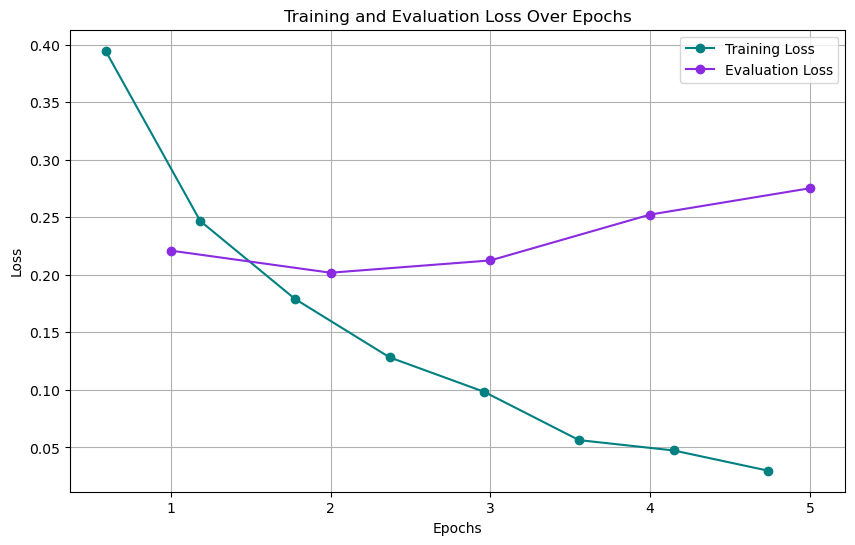

In [11]:
import matplotlib.pyplot as plt

# Initialize lists to store the losses and epochs
train_loss = []
eval_loss = []
epochs = []

# Extract the losses and epochs from the log history
for log in trainer.state.log_history:
    if 'loss' in log and 'epoch' in log:  # Training loss
        train_loss.append(log['loss'])
        epochs.append(log['epoch'])
    if 'eval_loss' in log and 'epoch' in log:  # Evaluation loss
        eval_loss.append(log['eval_loss'])

# Ensure the epochs list is aligned with eval_loss if needed
eval_epochs = epochs[:len(eval_loss)] if len(eval_loss) == len(epochs) else list(range(1, len(eval_loss) + 1))


plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(epochs, train_loss, label='Training Loss', marker='o', linestyle='-')

# Plot evaluation loss
plt.plot(eval_epochs, eval_loss, label='Evaluation Loss', marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Over Epochs')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


### Automated Checkpoint Selection

While effective, this manual approach has some limitations:
- **Subjectivity**: Visual inspection is subjective and may not be consistent across different viewers or datasets.
- **Time-consuming**: Manually inspecting plots is feasible for a few experiments, but it becomes cumbersome when training multiple models or fine-tuning hyperparameters.

### Automated Checkpoint Selection

To streamline this process and make it more objective, we can leverage the `trainer.state.best_model_checkpoint` feature provided by the Hugging Face Trainer API. This feature automatically tracks the checkpoint with the best performance on the validation set during training, based on a specified metric (e.g., evaluation loss, F1 score, accuracy).


In [12]:
import re

# Get the best model checkpoint from the trainer state object
best_model_checkpoint = trainer.state.best_model_checkpoint

#temp fix
best_model_checkpoint = best_model_checkpoint.replace('training_local_dir', 'buckets/models-ckpt-bkt')

# Extract the step number from the best model checkpoint name
# Assuming the format is like 'checkpoint-1688' at the end of the path
step_match = re.search(r'checkpoint-(\d+)', best_model_checkpoint)
best_checkpoint_step = int(step_match.group(1)) if step_match else None

# Initialize variables to store metrics
eval_f1, eval_recall, eval_accuracy = None, None, None

# Search for the relevant evaluation metrics in log_history
for log in trainer.state.log_history:
    if 'eval_f1' in log and log.get('step') == best_checkpoint_step:
        eval_f1 = log['eval_f1']
        eval_recall = log.get('eval_recall', None)
        eval_accuracy = log.get('eval_accuracy', None)
        break  # Once the metrics are found, exit the loop

# Print the metrics for the best model
if eval_f1 is not None:
    print(f"The best for checkpoint model {trainer.model.config.name_or_path} is:")
    print(f"Checkpoint: {best_model_checkpoint} (Step: {best_checkpoint_step}) :")
    print(f"F1 Score: {eval_f1:.4f}")
    print(f"Recall: {eval_recall:.4f}")
    print(f"Accuracy: {eval_accuracy:.4f}")


The best for checkpoint model Dr-BERT/DrBERT-4GB is:
Checkpoint: /home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner-Dr-BERT/DrBERT-4GB/checkpoint-1688 (Step: 1688) :
F1 Score: 0.7315
Recall: 0.7479
Accuracy: 0.9324


Let’s now test the best checkpoint for this Healthcare NER Model

In [13]:
from transformers import pipeline

# test the healthcare NER model
token_classifier = pipeline("token-classification", model=best_model_checkpoint, aggregation_strategy="first")
token_classifier("Le medecin donne des antibiotiques pour les infections bactériennes.")


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'entity_group': 'MedicationVaccine',
  'score': 0.85936165,
  'word': 'antibiotiques',
  'start': 20,
  'end': 34}]

The newly fine-tuned Healthcare NER model successfully identified "antibiotiques" as a "MedicationVaccine" entity. This suggests that the model is effectively identifying medical entities within medical text. 

Repeat the fine-tuning process for each of the top-5 MLM Models:
1. Dr-BERT/DrBERT-4GB
2. abazoge/DrBERT-4096
3. Dr-BERT/DrBERT-7GB
4. almanach/camembert-bio-base
5. Dr-BERT/DrBERT-4GB-CP-PubMedBERT

To do this, restart this notebook and changing the model_checkpoint at the cell: Set Pre-Trained Models for Fine-Tuning.


This concludes the notebook.
